<font>
<div dir=ltr align=center>
<img src='https://cdn.freebiesupply.com/logos/large/2x/sharif-logo-png-transparent.png' width=150 height=150> <br>
<font color=0F5298 size=6>
Machine Learning<br>
<font color=2565AE size=4>
Computer Engineering Department<br>
Fall 2025<br>
<font color=3C99D size=4>
Homework 3 - Practical<br>
<font color=696880 size=3>

# Student Information

In [35]:
student_number = '402110876'
full_name = 'alireza sarbaz'

# Libraries

In [36]:
import math
import time
import copy
import numpy as np
import matplotlib.pyplot as plt

# Part 1: Dataset

In [37]:
def set_seed(seed=42):
    """Return a NumPy Generator for reproducibility."""
    generator = np.random.default_rng(seed)
    return generator


def train_val_split(X, y, val_ratio=0.2, seed=42):
    """Split X, y into train/val using a shuffled index.

    Returns:
        X_train, y_train, X_val, y_val
    """
    generator = set_seed(seed)
    n = X.shape[0]
    idx = np.arange(n)
    generator.shuffle(idx)

    # Calculate number of validation samples
    num_val = int(n * val_ratio)
    val_idx = idx[:num_val]
    train_idx = idx[num_val:]
    
    # Return split data
    return X[train_idx], y[train_idx], X[val_idx], y[val_idx]

def standardize(X_train, X_val):
    """Standardize features using train mean/std and apply to val."""
    # Compute mean and std from training data only
    mean = np.mean(X_train, axis=0)
    std = np.std(X_train, axis=0)
    
    # Avoid division by zero
    std = np.where(std == 0, 1.0, std)
    
    # Normalize both sets using train statistics
    X_train_norm = (X_train - mean) / std
    X_val_norm = (X_val - mean) / std
    
    return X_train_norm, X_val_norm

In [38]:
def make_blobs(n_samples=1000, n_features=2, centers=3, cluster_std=1.0, seed=42):
    """Generate a simple clustered dataset (features X, integer labels y)."""
    generator = set_seed(seed)
    
    # Divide samples among centers (approximately equal)
    samples_per_center = n_samples // centers
    remainder = n_samples % centers
    
    # Generate random centers in feature space
    cluster_centers = generator.uniform(-10, 10, size=(centers, n_features))
    
    X_list = []
    y_list = []
    
    # Generate samples for each cluster
    for i in range(centers):
        # Number of samples for this cluster
        n_cluster = samples_per_center + (1 if i < remainder else 0)
        
        # Generate samples with normal distribution around center
        X_cluster = generator.normal(
            loc=cluster_centers[i], 
            scale=cluster_std, 
            size=(n_cluster, n_features)
        )
        
        # Labels for this cluster
        y_cluster = np.full(n_cluster, i, dtype=np.int64)
        
        X_list.append(X_cluster)
        y_list.append(y_cluster)
    
    # Concatenate all clusters
    X = np.vstack(X_list)
    y = np.hstack(y_list)
    
    # Shuffle the data
    idx = np.arange(n_samples)
    generator.shuffle(idx)
    
    return X[idx], y[idx]


In [39]:
X, y = make_blobs(n_samples=1200, n_features=10, centers=5, cluster_std=1.3)
X_train_raw, y_train_raw, X_val_raw, y_val_raw = train_val_split(X, y, val_ratio=0.2)
X_train, X_val = standardize(X_train_raw, X_val_raw)
y_train, y_val = y_train_raw, y_val_raw

In [40]:
num_classes = int(y.max() + 1)
input_dim = X_train.shape[1]
print('Train shape:', X_train.shape, 'Val shape:', X_val.shape, 'Classes:', num_classes)

Train shape: (960, 10) Val shape: (240, 10) Classes: 5


# Part 2: MLP Layers

In [41]:
class Layer:
    """Base class for layers."""

    def __init__(self):
        # You usually do NOT change this part.
        # It provides dictionaries that child classes will fill.
        self.params = {}
        self.grads = {}

    def forward(self, x, training=True):
        """Forward pass of the layer. """
        raise NotImplementedError("forward() must be implemented in subclasses.")

    def backward(self, dout):
        """Backward pass of the layer."""
        raise NotImplementedError("backward() must be implemented in subclasses.")

    def parameters(self):
        """Yield (name, param_array, grad_array) pairs for trainer/optimizer.        """
        for k, v in self.params.items():
            yield k, v, self.grads[k]

In [42]:
class Linear(Layer):
    """Affine layer: y = xW + b."""

    def __init__(self, in_features, out_features, init='he', seed=42):
        super().__init__()

        if init == 'xavier':
            scale = math.sqrt(2.0 / (in_features + out_features))
        else:
            # He is the default for ReLU
            scale = math.sqrt(2.0 / in_features)

        generator = np.random.default_rng(seed)
        W = generator.normal(0.0, scale, size=(in_features, out_features)).astype(np.float64)
        b = np.zeros((out_features,), dtype=np.float64)

        self.params['W'] = W
        self.params['b'] = b
        self.grads['W'] = np.zeros_like(W)
        self.grads['b'] = np.zeros_like(b)
        self.cache = None

    def forward(self, x, training=True):
        """Forward pass of the linear layer."""
        # Cache x for backward pass
        self.cache = x
        
        # Compute affine transformation: out = x @ W + b
        out = x @ self.params['W'] + self.params['b']
        
        return out

    def backward(self, dout):
        """Backward pass of the linear layer."""
        # Get x from cache
        x = self.cache
        
        # Compute gradients
        dW = x.T @ dout
        db = dout.sum(axis=0)
        
        # Store gradients
        self.grads['W'][...] = dW
        self.grads['b'][...] = db
        
        # Compute gradient w.r.t. input
        dx = dout @ self.params['W'].T
        
        return dx


In [43]:
class ReLU(Layer):
    """Rectified Linear Unit: ReLU(x) = max(0, x)."""

    def __init__(self):
        super().__init__()
        # Will store a boolean mask of where x > 0
        self.mask = None

    def forward(self, x, training=True):
        """Forward pass for ReLU."""
        # Create boolean mask for x > 0
        self.mask = (x > 0)
        
        # Apply ReLU: out = x * mask (equivalent to max(0, x))
        out = x * self.mask
        
        return out

    def backward(self, dout):
        """Backward pass for ReLU."""
        # Propagate gradients only where x > 0
        dx = dout * self.mask
        
        return dx


class Tanh(Layer):
    """Elementwise tanh activation."""

    def __init__(self):
        super().__init__()
        # Will cache the output tanh(x) for use in backward
        self.cache = None

    def forward(self, x, training=True):
        """Forward pass for tanh."""
        # Compute tanh elementwise
        out = np.tanh(x)
        
        # Cache output for backward pass
        self.cache = out
        
        return out

    def backward(self, dout):
        """Backward pass for tanh."""
        # Retrieve cached output
        out = self.cache
        
        # Compute gradient: d/dx tanh(x) = 1 - tanh^2(x)
        dx = dout * (1 - out * out)
        
        return dx


In [44]:
class Dropout(Layer):
    """Inverted Dropout."""

    def __init__(self, p=0.5, seed=42):
        super().__init__()
        assert 0.0 <= p < 1.0

        self.p = float(p)
        self.keep = 1.0 - self.p          # keep probability
        self.generator = np.random.default_rng(seed)
        self.mask = None                  # will store dropout mask

    def forward(self, x, training=True):
        """Forward pass for inverted dropout."""
        # Evaluation mode or no dropout
        if not training or self.p == 0.0:
            self.mask = None
            return x
        
        # Training mode: sample mask and apply inverted dropout
        keep_prob = self.keep
        raw_mask = (self.generator.random(x.shape) < keep_prob)
        mask = raw_mask.astype(np.float64) / keep_prob
        
        self.mask = mask
        return x * mask

    def backward(self, dout):
        """Backward pass for inverted dropout."""
        # If no mask (eval mode), return gradient unchanged
        if self.mask is None:
            return dout
        
        # Apply the same mask to gradients
        return dout * self.mask


In [45]:
class BatchNorm1d(Layer):
    """Batch Normalization for 2D inputs (N, D)."""

    def __init__(self, num_features, momentum=0.9, eps=1e-5):
        super().__init__()

        # Learnable scale and shift parameters
        self.params['gamma'] = np.ones((num_features,), dtype=np.float64)
        self.params['beta'] = np.zeros((num_features,), dtype=np.float64)
        self.grads['gamma'] = np.zeros_like(self.params['gamma'])
        self.grads['beta'] = np.zeros_like(self.params['beta'])

        # Running statistics for inference
        self.momentum = momentum
        self.eps = eps
        self.running_mean = np.zeros((num_features,), dtype=np.float64)
        self.running_var = np.ones((num_features,), dtype=np.float64)

        # To store intermediates needed in backward
        self.cache = None

    def forward(self, x, training=True):
        """Forward pass for BatchNorm1d."""
        gamma = self.params['gamma']
        beta = self.params['beta']
        
        if training:
            # Training mode: compute batch statistics
            mu = x.mean(axis=0)
            var = x.var(axis=0)
            
            # Normalize
            x_mu = x - mu
            std_inv = 1.0 / np.sqrt(var + self.eps)
            x_hat = x_mu * std_inv
            
            # Scale and shift
            out = gamma * x_hat + beta
            
            # Update running statistics
            self.running_mean = self.momentum * self.running_mean + (1 - self.momentum) * mu
            self.running_var = self.momentum * self.running_var + (1 - self.momentum) * var
            
            # Cache for backward
            self.cache = (x, x_hat, mu, var, std_inv)
        else:
            # Evaluation mode: use running statistics
            x_hat = (x - self.running_mean) / np.sqrt(self.running_var + self.eps)
            out = gamma * x_hat + beta
        
        return out

    def backward(self, dout):
        """Backward pass for BatchNorm1d."""
        # Unpack cache
        x, x_hat, mu, var, std_inv = self.cache
        gamma = self.params['gamma']
        N, D = x.shape
        
        # Compute gradients w.r.t. gamma and beta
        dgamma = (dout * x_hat).sum(axis=0)
        dbeta = dout.sum(axis=0)
        
        # Store gradients
        self.grads['gamma'][...] = dgamma
        self.grads['beta'][...] = dbeta
        
        # Backprop through normalization
        dx_hat = dout * gamma
        
        # Compute gradients w.r.t. variance and mean
        dvar = (dx_hat * (x - mu)).sum(axis=0) * (-0.5) * (std_inv ** 3)
        dmu = (dx_hat * -std_inv).sum(axis=0) + dvar * np.mean(-2 * (x - mu), axis=0)
        
        # Compute gradient w.r.t. input
        dx = dx_hat * std_inv + dvar * 2 * (x - mu) / N + dmu / N
        
        return dx


# Part 3: Loss

In [46]:
def softmax_cross_entropy(logits, y):
    """Stable softmax + cross-entropy for integer labels."""

    # For numerical stability, shift logits by the max value in each row
    shifted = logits - logits.max(axis=1, keepdims=True)

    # Compute exponentials of the shifted logits
    exp = np.exp(shifted)

    # Compute softmax probabilities
    probs = exp / exp.sum(axis=1, keepdims=True)

    # Compute the cross-entropy loss
    N = logits.shape[0]
    # For each sample i, get the correct class probability: probs[i, y[i]]
    # Use epsilon for numerical stability
    loss = -np.log(probs[np.arange(N), y] + 1e-12).mean()

    # Compute the gradient dL/dlogits (dlogits)
    # Start from probs and subtract 1 from the true class probability
    dlogits = probs.copy()
    dlogits[np.arange(N), y] -= 1
    # Divide by N to get the mean gradient
    dlogits /= N

    # Return loss and dlogits
    return loss, dlogits


# Part 4: MLP

In [47]:
class MLP:
    """Multi-Layer Perceptron with optional BatchNorm and Dropout."""

    def __init__(self, input_dim, hidden_sizes, num_classes,
                 activation='relu', use_batchnorm=False, dropout_p=0.0, init='he', seed=42):
        # You usually don't need to change this constructor.
        # It builds a sequence of layers (Linear / BatchNorm / Activation / Dropout).
        self.layers = []
        generator = np.random.default_rng(seed)
        act_cls = ReLU if activation == 'relu' else Tanh
        dims = [input_dim] + list(hidden_sizes) + [num_classes]

        for i in range(len(dims) - 1):
            # Linear layer
            self.layers.append(
                Linear(dims[i], dims[i + 1], init=init, seed=int(generator.integers(0, 1e9)))
            )
            # Hidden layers: optional BatchNorm + Activation + optional Dropout
            if i < len(dims) - 2:
                if use_batchnorm:
                    self.layers.append(BatchNorm1d(dims[i + 1]))
                self.layers.append(act_cls())
                if dropout_p and dropout_p > 0.0:
                    self.layers.append(Dropout(p=dropout_p, seed=int(generator.integers(0, 1e9))))

        self.training = True

    def forward(self, x, training=True):
        """Forward pass of the MLP."""
        # Forward pass through all layers
        out = x
        for layer in self.layers:
            out = layer.forward(out, training=training)
        return out

    def backward(self, dout):
        """Backward pass of the MLP."""
        # Backward pass through all layers in reverse order
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def parameters(self):
        """Yield all (id, name, param, grad, layer) tuples for optimizers."""
        # Yield all trainable parameters from all layers
        for layer in self.layers:
            if isinstance(layer, Layer):
                for name, param, grad in layer.parameters():
                    yield (id(param), name, param, grad, layer)

    def zero_grads(self):
        """Zero all parameter gradients. """
        # Zero out all parameter gradients
        for _, _, _, grad, _ in self.parameters():
            grad[...] = 0.0

    def predict(self, x):
        """Return argmax class predictions (eval mode)."""
        # Forward pass in evaluation mode and return argmax predictions
        logits = self.forward(x, training=False)
        preds = logits.argmax(axis=1)
        return preds

    def accuracy(self, x, y):
        """Compute classification accuracy."""
        # Get predictions and compute accuracy
        preds = self.predict(x)
        acc = (preds == y).mean()
        return acc


## Numerical gradient check (sanity)
We compare analytical gradients vs. finite differences on a tiny network and batch.

In [48]:
def numerical_grad_check(model, X_batch, y_batch, eps=1e-5, atol=1e-6, rtol=1e-3, verbose=False):
    """Finite-difference gradient check."""

    # Run a forward pass through the model to get logits
    logits = model.forward(X_batch, training=True)

    # Compute the loss and the gradient w.r.t. logits using softmax_cross_entropy
    loss, dout = softmax_cross_entropy(logits, y_batch)

    # Zero out all gradients in the model
    model.zero_grads()

    # Run a backward pass to fill analytic gradients in model parameters
    model.backward(dout)

    # Initialize a flag ok = True to track if all checks pass
    ok = True

    # Loop over all parameters using model.parameters()
    for pid, name, param, grad, layer in model.parameters():
        # Skip if grad is None or param is None
        if grad is None or param is None:
            continue
        
        # Flatten param and grad to 1D views
        flat = param.reshape(-1)
        gflat = grad.reshape(-1)
        
        # Choose up to 5 random indices to check using a fixed RNG seed for reproducibility
        rng = np.random.default_rng(0)
        idxs = rng.choice(len(flat), size=min(5, len(flat)), replace=False)

        # For each chosen index idx
        for idx in idxs:
            # Save the original value
            old = flat[idx]
            
            # Compute loss_pos
            flat[idx] = old + eps
            logits_pos = model.forward(X_batch, training=True)
            loss_pos, _ = softmax_cross_entropy(logits_pos, y_batch)
            
            # Compute loss_neg
            flat[idx] = old - eps
            logits_neg = model.forward(X_batch, training=True)
            loss_neg, _ = softmax_cross_entropy(logits_neg, y_batch)
            
            # Restore original value
            flat[idx] = old
            
            # Compute numerical gradient
            g_num = (loss_pos - loss_neg) / (2 * eps)
            
            # Get analytic gradient
            g_ana = gflat[idx]

            # Compare numeric vs analytic using np.isclose
            if not np.isclose(g_num, g_ana, atol=atol, rtol=rtol):
                ok = False
                if verbose:
                    print(f"Grad mismatch in {layer.__class__.__name__}.{name}: "
                          f"numeric={g_num:.6e}, analytic={g_ana:.6e}")

    # After checking all parameters and indices, return ok
    return ok


In [49]:
# Run a quick check (no dropout during grad check)
Xb = X_train[:8].astype(np.float64)
yb = y_train[:8]

tiny = MLP(input_dim=input_dim, hidden_sizes=[8], num_classes=num_classes,
           activation='relu', use_batchnorm=True, dropout_p=0.0, init='he', seed=123)

ok = numerical_grad_check(tiny, Xb, yb, eps=1e-6, atol=1e-8, rtol=1e-5, verbose=True)

print('Gradient check passed?', ok)

Gradient check passed? True


# Part 4: Optimizers
We implement: SGD, Momentum, Nesterov, RMSProp, Adam, AdamW (decoupled weight decay).

In [50]:
class Optimizer:
    """Base optimizer holding a learning rate and per-parameter state."""

    def __init__(self, lr=1e-2):
        # Global learning rate for this optimizer
        self.lr = lr
        # Per-parameter state, keyed by parameter id (pid)
        self.state = {}

    def step(self, params_and_grads):
        """Apply one update step to all parameters."""
        raise NotImplementedError("step() must be implemented in subclasses.")

    def _get_state(self, pid):
        """Return (and lazily create) a state dict for parameter with id=pid."""
        if pid not in self.state:
            self.state[pid] = {}
        return self.state[pid]


In [51]:
class SGD(Optimizer):
    """Stochastic Gradient Descent (SGD)"""

    def step(self, params_and_grads):
        """Apply one SGD update to all parameters."""
        # Loop over all parameters and apply SGD update
        for pid, name, p, g, layer in params_and_grads:
            # Skip if gradient is None
            if g is None:
                continue
            # Update parameter in-place: w = w - lr * g
            p[...] = p - self.lr * g


In [52]:
class SGDMomentum(Optimizer):
    """SGD with momentum (Polyak)

    State per parameter: velocity v.

    Update at step t:
      v = mu * v - lr * g
      w = w + v

    Where mu is momentum in [0, 1).
    """

    def __init__(self, lr=1e-2, momentum=0.9):
        super().__init__(lr)
        self.momentum = momentum

    def step(self, params_and_grads):
        """Apply one SGD-with-momentum update to all parameters."""
        # Loop over all parameters and apply SGD with momentum update
        for pid, name, p, g, layer in params_and_grads:
            # Skip if gradient is None
            if g is None:
                continue
            
            # Get (or create) state dict for this parameter
            st = self._get_state(pid)
            
            # Get velocity from state, defaulting to zeros
            v = st.get('v', np.zeros_like(p))
            
            # Update velocity: v = mu * v - lr * g
            v = self.momentum * v - self.lr * g
            
            # Update parameter: w = w + v
            p[...] = p + v
            
            # Store updated velocity back into state
            st['v'] = v


In [53]:
class Nesterov(Optimizer):
    """Nesterov accelerated gradient (lookahead momentum)

    State per parameter: velocity v.

    Practical single-gradient update (equivalent to lookahead form):
      v_t = mu * v_prev - lr * g_t
      w_{t+1} = w_t + ( -mu * v_prev + (1 + mu) * v_t )

    This matches computing the gradient at the lookahead point
    (w_t + mu * v_prev) without an extra forward/backward pass.
    """

    def __init__(self, lr=1e-2, momentum=0.9):
        super().__init__(lr)
        self.momentum = momentum

    def step(self, params_and_grads):
        """Apply one Nesterov accelerated gradient update to all parameters."""
        # Loop over all parameters and apply Nesterov update
        for pid, name, p, g, layer in params_and_grads:
            # Skip if gradient is None
            if g is None:
                continue
            
            # Get (or create) state dict for this parameter
            st = self._get_state(pid)
            
            # Get previous velocity from state, defaulting to zeros
            v_prev = st.get('v', np.zeros_like(p))
            
            # Compute new velocity: v = mu * v_prev - lr * g
            v = self.momentum * v_prev - self.lr * g
            
            # Update parameter using Nesterov rule: w = w + (-mu * v_prev + (1 + mu) * v)
            p[...] = p + (-self.momentum * v_prev + (1 + self.momentum) * v)
            
            # Store updated velocity back to state
            st['v'] = v


In [54]:
class RMSProp(Optimizer):
    """RMSProp"""

    def __init__(self, lr=1e-3, rho=0.9, eps=1e-8):
        super().__init__(lr)
        self.rho = rho
        self.eps = eps

    def step(self, params_and_grads):
        """Apply one RMSProp update to all parameters."""
        # Loop over all parameters and apply RMSProp update
        for pid, name, p, g, layer in params_and_grads:
            # Skip if gradient is None
            if g is None:
                continue
            
            # Get (or create) state dict for this parameter
            st = self._get_state(pid)
            
            # Retrieve running average of squared gradients, defaulting to zeros
            cache = st.get('cache', np.zeros_like(p))
            
            # Update running average: s = rho * s + (1 - rho) * (g^2)
            cache = self.rho * cache + (1 - self.rho) * (g * g)
            
            # Compute parameter update: w = w - lr * g / (sqrt(s) + eps)
            p[...] = p - self.lr * g / (np.sqrt(cache) + self.eps)
            
            # Store updated cache back into state
            st['cache'] = cache


In [55]:
class Adam(Optimizer):
    """Adam (with optional decoupled weight decay, AdamW)"""

    def __init__(self, lr=1e-3, beta1=0.9, beta2=0.999, eps=1e-8, weight_decay=0.0, decoupled=False):
        super().__init__(lr)

        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.weight_decay = weight_decay
        # AdamW when True
        self.decoupled = decoupled
        # Global time step (starts at 0, incremented each step)
        self.t = 0

    def step(self, params_and_grads):
        """Apply one Adam / AdamW update to all parameters."""
        # Increment global time step
        self.t += 1

        # Loop over all parameters and apply Adam / AdamW update
        for pid, name, p, g, layer in params_and_grads:
            # Skip if gradient is None
            if g is None:
                continue
            
            # Get (or create) state dict for this parameter
            st = self._get_state(pid)
            
            # Retrieve first and second moments, defaulting to zeros
            m = st.get('m', np.zeros_like(p))
            v = st.get('v', np.zeros_like(p))
            
            # If using decoupled weight decay (AdamW)
            if self.decoupled and self.weight_decay > 0.0:
                p[...] = p - self.lr * self.weight_decay * p
            
            # Update biased first and second moments
            m = self.beta1 * m + (1 - self.beta1) * g
            v = self.beta2 * v + (1 - self.beta2) * (g * g)
            
            # Compute bias-corrected moments
            m_hat = m / (1 - self.beta1 ** self.t)
            v_hat = v / (1 - self.beta2 ** self.t)
            
            # Apply Adam parameter update: w = w - lr * m_hat / (sqrt(v_hat) + eps)
            p[...] = p - self.lr * m_hat / (np.sqrt(v_hat) + self.eps)
            
            # Store updated moments back into state
            st['m'] = m
            st['v'] = v


# Part 5: L1/L2 Regularization

In [56]:
def apply_weight_regularization(model, l1=0.0, l2=0.0):
    """Add L1/L2 penalties to Linear weights and accumulate gradients."""

    # Start with zero regularization loss
    regularization_loss = 0.0

    # Loop over all layers in model.layers
    for layer in model.layers:
        # Check if the layer is an instance of Linear
        if isinstance(layer, Linear):
            # Extract the weight matrix W and its gradient dW
            W = layer.params['W']
            dW = layer.grads['W']
            
            # If l2 > 0.0, add L2 regularization
            if l2 > 0.0:
                # Add L2 penalty to the loss: 0.5 * l2 * ||W||^2
                regularization_loss += 0.5 * l2 * np.sum(W * W)
                # Add gradient contribution to dW: l2 * W
                dW[...] += l2 * W
            
            # If l1 > 0.0, add L1 regularization
            if l1 > 0.0:
                # Add L1 penalty to the loss: l1 * |W|
                regularization_loss += l1 * np.sum(np.abs(W))
                # Add gradient contribution using sign of W: l1 * sign(W)
                dW[...] += l1 * np.sign(W)
    
    # After processing all Linear layers, return regularization_loss
    return regularization_loss


# Part 6: Training Loop

In [57]:
def iterate_minibatches(X, y, batch_size, shuffle=True, seed=42):
    """Yield mini-batches (Xb, yb)."""

    # Get a random generator using the provided seed.
    generator = set_seed(seed)

    # Get number of samples N from X.shape[0]:
    n = X.shape[0]

    # Create an array of indices from 0 to n-1:
    idx = np.arange(n)

    # If shuffle is True, shuffle the indices in-place:
    if shuffle:
        generator.shuffle(idx)

    # Loop over start indices from 0 to n in steps of batch_size:
    for start_idx in range(0, n, batch_size):
        end_idx = min(start_idx + batch_size, n)
        batch_idx = idx[start_idx:end_idx]
        yield X[batch_idx], y[batch_idx]


In [58]:
def train(model, optimizer, X_train, y_train, X_val, y_val,
          epochs=30, batch_size=64, l1=0.0, l2=0.0,
          early_stopping_patience=5, seed=42, verbose=True,
          micro_batch_size=None):
    """Training loop with optional micro-batching (gradient accumulation). """

    # Initialize bookkeeping variables
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }
    train_losses = []  # Per-batch losses for current epoch
    best_val_loss = float('inf')
    best_params = None
    patience_counter = 0
    
    # Determine if we should use micro-batching
    use_micro_batching = (micro_batch_size is not None and 
                         micro_batch_size < batch_size and 
                         micro_batch_size > 0)

    # Epoch loop:
    import time
    for epoch in range(epochs):
        epoch_start_time = time.time()
        train_losses = []  # Reset per-epoch batch losses
        
        # Iterate over training batches
        for Xb, yb in iterate_minibatches(X_train, y_train, batch_size, shuffle=True, seed=seed + epoch):
            
            if not use_micro_batching:
                # 3a.1: Forward pass on the batch:
                logits = model.forward(Xb, training=True)
                
                # 3a.2: Compute loss and gradient w.r.t logits:
                loss, dout = softmax_cross_entropy(logits, yb)
                
                # 3a.3: Zero model gradients:
                model.zero_grads()
                
                # 3a.4: Backward pass:
                model.backward(dout)
                
                # 3a.5: Apply weight regularization (adds to loss and grads):
                reg_loss = apply_weight_regularization(model, l1=l1, l2=l2)
                total_loss = loss + reg_loss
                
                # 3a.6: Optimizer step:
                optimizer.step(model.parameters())
                
                # 3a.7: Append the scalar loss to train_losses:
                train_losses.append(total_loss)
            else:
                # 3b.1: Let Nvirt = len(Xb)  (logical batch size)
                Nvirt = len(Xb)
                
                # 3b.2: Zero model gradients before accumulation:
                model.zero_grads()
                
                # 3b.3: Initialize total_loss = 0.0
                total_loss = 0.0
                
                # 3b.4: Split Xb, yb into micro-batches of size micro_batch_size:
                for X_micro, y_micro in iterate_minibatches(Xb, yb, micro_batch_size, shuffle=False, seed=seed + epoch):
                    # Forward pass on micro-batch
                    logits_micro = model.forward(X_micro, training=True)
                    
                    # Compute loss and gradient
                    loss_micro, dout_micro = softmax_cross_entropy(logits_micro, y_micro)
                    
                    # Scale gradient by micro_batch_size / Nvirt to get mean over logical batch
                    scale = len(X_micro) / Nvirt
                    dout_micro = dout_micro * scale
                    
                    # Backward pass (gradients accumulate)
                    model.backward(dout_micro)
                    
                    # Accumulate loss (weighted by micro-batch size)
                    total_loss += loss_micro * len(X_micro) / Nvirt
                
                # 3b.5: After loop, apply weight regularization:
                reg_loss = apply_weight_regularization(model, l1=l1, l2=l2)
                total_loss = total_loss + reg_loss
                
                # 3b.6: One optimizer step:
                optimizer.step(model.parameters())
                
                # 3b.7: Append total_loss to train_losses:
                train_losses.append(total_loss)
        
        # 4: Compute epoch-level statistics:
        epoch_train_loss = np.mean(train_losses)
        epoch_train_acc = model.accuracy(X_train, y_train)
        
        # Validation evaluation (in eval mode)
        val_logits = model.forward(X_val, training=False)
        val_loss, _ = softmax_cross_entropy(val_logits, y_val)
        val_reg_loss = apply_weight_regularization(model, l1=l1, l2=l2)
        epoch_val_loss = val_loss + val_reg_loss
        epoch_val_acc = model.accuracy(X_val, y_val)
        
        # 5: Log to history:
        history['train_loss'].append(epoch_train_loss)
        history['val_loss'].append(epoch_val_loss)
        history['train_acc'].append(epoch_train_acc)
        history['val_acc'].append(epoch_val_acc)
        
        # 6: If verbose, print progress, including epoch, losses, accs
        if verbose:
            epoch_time = time.time() - epoch_start_time
            print(f'Epoch {epoch+1:02d} | train_loss={epoch_train_loss:.4f} val_loss={epoch_val_loss:.4f} '
                  f'train_acc={epoch_train_acc:.3f} val_acc={epoch_val_acc:.3f} ({epoch_time:.2f}s)')
        
        # 7: Early stopping:
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            # Save best model parameters
            best_params = {}
            for pid, name, param, _, _ in model.parameters():
                best_params[pid] = param.copy()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                if verbose:
                    print(f'Early stopping at epoch {epoch+1}')
                break
    
    # 8: After training loop, if best_params is not None,
    if best_params is not None:
        # Restore best parameters
        for pid, name, param, _, _ in model.parameters():
            if pid in best_params:
                param[...] = best_params[pid]
    
    # 9: Finally, return history.
    return history


In [59]:
model = MLP(
    input_dim=X_train.shape[1],
    hidden_sizes=[64, 64],
    num_classes=int(y_train.max() + 1),
    activation='relu',
    use_batchnorm=False,
    dropout_p=0.0,
    init='he',
    seed=123,
)

optimizer = Adam(lr=1e-3)

history = train(model, optimizer, X_train, y_train, X_val, y_val,
    epochs=80, batch_size=64, l1=0.0, l2=0.0, early_stopping_patience=12, seed=1, verbose=True, micro_batch_size=None)

val_acc = model.accuracy(X_val, y_val)
print('Final val_acc =', val_acc)

assert val_acc >= 0.99, 'Expected ~100% val accuracy on the blobs sanity run.'

Epoch 01 | train_loss=1.4443 val_loss=0.6097 train_acc=0.968 val_acc=0.946 (0.01s)
Epoch 02 | train_loss=0.2993 val_loss=0.1139 train_acc=1.000 val_acc=1.000 (0.01s)
Epoch 03 | train_loss=0.0704 val_loss=0.0380 train_acc=1.000 val_acc=1.000 (0.01s)
Epoch 04 | train_loss=0.0296 val_loss=0.0205 train_acc=1.000 val_acc=1.000 (0.01s)
Epoch 05 | train_loss=0.0180 val_loss=0.0139 train_acc=1.000 val_acc=1.000 (0.01s)
Epoch 06 | train_loss=0.0130 val_loss=0.0104 train_acc=1.000 val_acc=1.000 (0.01s)
Epoch 07 | train_loss=0.0099 val_loss=0.0082 train_acc=1.000 val_acc=1.000 (0.01s)
Epoch 08 | train_loss=0.0079 val_loss=0.0066 train_acc=1.000 val_acc=1.000 (0.01s)
Epoch 09 | train_loss=0.0066 val_loss=0.0055 train_acc=1.000 val_acc=1.000 (0.01s)
Epoch 10 | train_loss=0.0055 val_loss=0.0046 train_acc=1.000 val_acc=1.000 (0.01s)
Epoch 11 | train_loss=0.0047 val_loss=0.0040 train_acc=1.000 val_acc=1.000 (0.01s)
Epoch 12 | train_loss=0.0040 val_loss=0.0034 train_acc=1.000 val_acc=1.000 (0.01s)
Epoc

# Experiments

In [60]:
def plot_metric(history_list, labels, key, title):
    plt.figure(figsize=(6,4))
    for history, lab in zip(history_list, labels):
        plt.plot(history[key], label=lab)

    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel(key.replace('_', ' '))
    plt.legend()
    plt.show()

## Experiment A: Optimizer comparison (same budget)
We fix the model/seed and compare optimizers on the synthetic blobs (no dropout or L1/L2 to keep it clean).

In [61]:
histories = []
labels = []

for optimizer_name, optimizer in [
    ('SGD', SGD(lr=1e-1)),
    ('Momentum', SGDMomentum(lr=5e-2, momentum=0.9)),
    ('Nesterov', Nesterov(lr=5e-2, momentum=0.9)),
    ('RMSProp', RMSProp(lr=1e-3, rho=0.9)),
    ('Adam', Adam(lr=1e-3)),
    ('AdamW', Adam(lr=1e-3, weight_decay=1e-2, decoupled=True)),
]:
    model = MLP(input_dim=input_dim, hidden_sizes=[64, 64], num_classes=num_classes,
                activation='relu', use_batchnorm=False, dropout_p=0.0, init='he', seed=123)
    history = train(model, optimizer, X_train, y_train, X_val, y_val,
                    epochs=40, batch_size=64, l1=0.0, l2=0.0, early_stopping_patience=5, seed=123, verbose=False)

    print(f'{optimizer_name:8s} final val acc: {model.accuracy(X_val, y_val):.3f}')

    histories.append(history)
    labels.append(optimizer_name)

SGD      final val acc: 1.000
Momentum final val acc: 1.000
Nesterov final val acc: 1.000
RMSProp  final val acc: 1.000
Adam     final val acc: 1.000
AdamW    final val acc: 1.000


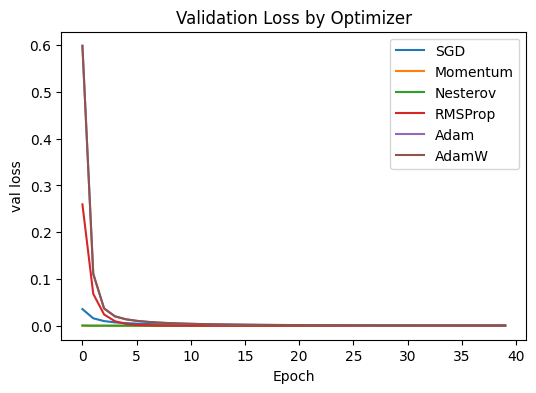

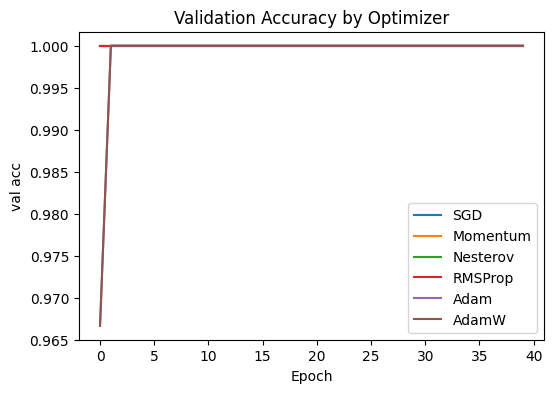

In [62]:
plot_metric(histories, labels, 'val_loss', 'Validation Loss by Optimizer')
plot_metric(histories, labels, 'val_acc', 'Validation Accuracy by Optimizer')

## Experiment B: Regularization ablation (L1/L2/Dropout)
We test None vs. **L2** vs. **L1** vs. **Dropout (p=0.5)**. Keep optimizer fixed for fairness.

In [63]:
histories = []
labels = []

for l1, l2, dropout_p, name in [
    (0.0, 0.0, 0.0, 'none'),
    (0.0, 1e-3, 0.0, 'L2=1e-3'),
    (1e-4, 0.0, 0.0, 'L1=1e-4'),
    (0.0, 0.0, 0.5, 'Dropout p=0.5'),
]:
    model = MLP(input_dim=input_dim, hidden_sizes=[64, 64], num_classes=num_classes,
                activation='relu', use_batchnorm=False, dropout_p=dropout_p, init='he', seed=123)
    opt = SGDMomentum(lr=5e-2, momentum=0.9)
    history = train(model, opt, X_train, y_train, X_val, y_val,
                 epochs=40, batch_size=64, l1=l1, l2=l2, early_stopping_patience=5, seed=123, verbose=False)
    val_acc = model.accuracy(X_val, y_val)
    print(f'{name:15s} | val_acc={val_acc:.3f}')

    histories.append(history)
    labels.append(name)

none            | val_acc=1.000
L2=1e-3         | val_acc=1.000
L1=1e-4         | val_acc=1.000
Dropout p=0.5   | val_acc=1.000


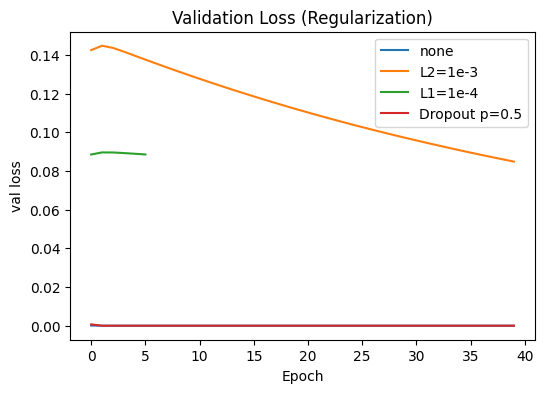

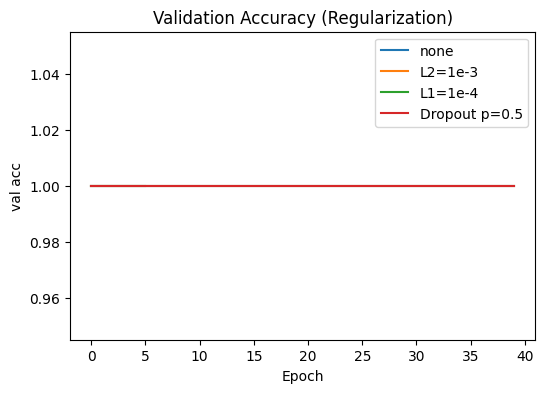

In [64]:
plot_metric(histories, labels, 'val_loss', 'Validation Loss (Regularization)')
plot_metric(histories, labels, 'val_acc', 'Validation Accuracy (Regularization)')

## Experiment C: BatchNorm on/off (with recommended ordering)
Compare MLP **with** vs. **without** BatchNorm (Linear -> BN -> ReLU -> [Dropout]). Keep optimizer and budget fixed.

In [65]:
def run_batch_norm(use_batch_norm, name):
    model = MLP(input_dim=input_dim, hidden_sizes=[64, 64], num_classes=num_classes,
                activation='relu', use_batchnorm=use_batch_norm, dropout_p=0.3, init='he', seed=123)
    optimizer = SGDMomentum(lr=5e-2, momentum=0.9)
    history = train(model, optimizer, X_train, y_train, X_val, y_val,
                 epochs=40, batch_size=64, l1=0.0, l2=0.0, early_stopping_patience=5, seed=123, verbose=False)
    val_acc = model.accuracy(X_val, y_val)

    print(f'{name:8s} | val_acc={val_acc:.3f}')
    return history, name

batch_norm_history, _ = run_batch_norm(True, 'with BN')
no_batch_norm_history, _ = run_batch_norm(False, 'no BN')

with BN  | val_acc=1.000
no BN    | val_acc=1.000


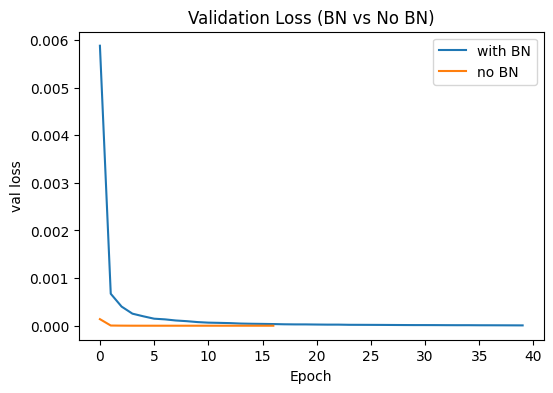

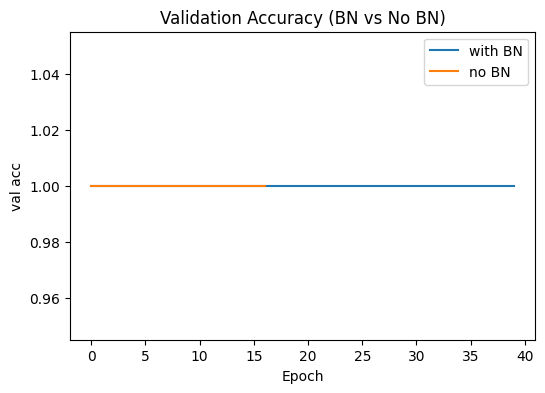

In [66]:
plot_metric([batch_norm_history, no_batch_norm_history], ['with BN', 'no BN'], 'val_loss', 'Validation Loss (BN vs No BN)')
plot_metric([batch_norm_history, no_batch_norm_history], ['with BN', 'no BN'], 'val_acc', 'Validation Accuracy (BN vs No BN)')

## Experiment C: Micro-batch ablation (Gradient Accumulation)
Keep optimizer fixed for fairness; hold logical batch_size constant
and vary micro_batch_size ∈ {None, 32, 16, 8, 4, 1}

no-accum     | val_acc=1.000
micro=32 (x2) | val_acc=1.000
micro=16 (x4) | val_acc=1.000
micro=8  (x8) | val_acc=1.000
micro=4  (x16) | val_acc=1.000
micro=1  (x64) | val_acc=1.000


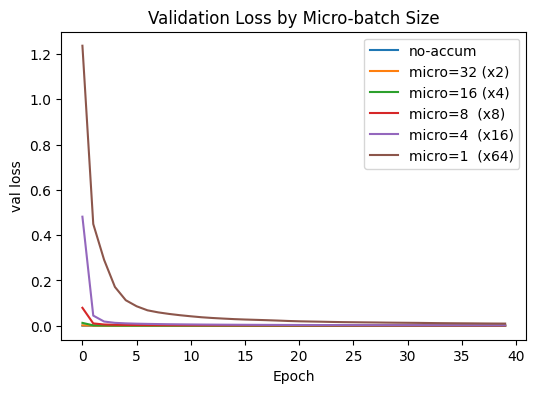

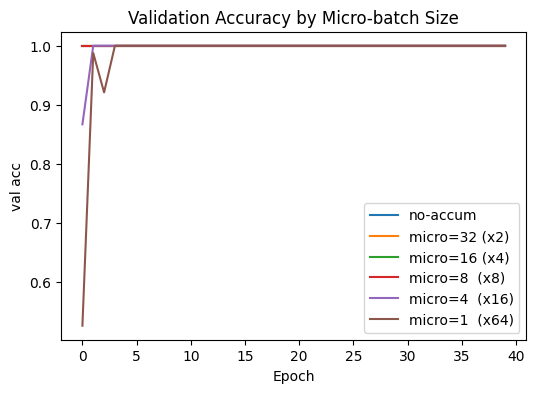

In [67]:
histories_mb = []
labels_mb = []

logical_batch_size = 64   
optimizer_ctor = lambda: SGDMomentum(lr=5e-2, momentum=0.9)  

for micro_bs, name in [
    (None, 'no-accum'),       
    (32,   'micro=32 (x2)'),   
    (16,   'micro=16 (x4)'),
    (8,    'micro=8  (x8)'),
    (4,    'micro=4  (x16)'),
    (1,    'micro=1  (x64)'),
]:
    model = MLP(input_dim=input_dim, hidden_sizes=[64, 64], num_classes=num_classes,
                activation='relu', use_batchnorm=False, dropout_p=0.0, init='he', seed=123)

    opt = optimizer_ctor()

    history = train(model, opt, X_train, y_train, X_val, y_val,
                    epochs=40,
                    batch_size=logical_batch_size,      
                    l1=0.0, l2=0.0,
                    early_stopping_patience=5,
                    seed=123,
                    verbose=False,
                    micro_batch_size=micro_bs)           

    val_acc = model.accuracy(X_val, y_val)
    print(f'{name:12s} | val_acc={val_acc:.3f}')

    histories_mb.append(history)
    labels_mb.append(name)

# Plot like before
plot_metric(histories_mb, labels_mb, 'val_loss', 'Validation Loss by Micro-batch Size')
plot_metric(histories_mb, labels_mb, 'val_acc',  'Validation Accuracy by Micro-batch Size')